I declare that this submission is my own work, and that I did not use any pretrained model or code that I did not explicitly cite.


In [33]:
# import libraries

# general libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# libraries for traing, testing, evaluating model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint



## Data Inspection


In [34]:
# Load data
data = np.load('dataset_dev_3000.npz')

# Explore keys
print("Keys:", data.files)

# Extract arrays
X = data['X']
y = data['y']

print("X shape:", X.shape)
print("y shape:", y.shape)


Keys: ['X', 'y']
X shape: (3000, 32, 32)
y shape: (3000, 3)


In [35]:
# Count number of samples per class
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")


Class 0.0: 387 samples
Class 0.00026430911384522915: 1 samples
Class 0.0012721653329208493: 1 samples
Class 0.001568699604831636: 1 samples
Class 0.001762773492373526: 1 samples
Class 0.0018284324323758483: 1 samples
Class 0.0019072487484663725: 1 samples
Class 0.0020356904715299606: 1 samples
Class 0.0021006499882787466: 1 samples
Class 0.0026393872685730457: 1 samples
Class 0.003119604429230094: 1 samples
Class 0.0033321119844913483: 1 samples
Class 0.0034062291961163282: 1 samples
Class 0.0035183411091566086: 1 samples
Class 0.003814652096480131: 1 samples
Class 0.003852665890008211: 1 samples
Class 0.003922072239220142: 1 samples
Class 0.004057707265019417: 1 samples
Class 0.004159008618444204: 1 samples
Class 0.004307989031076431: 1 samples
Class 0.0043214308097958565: 1 samples
Class 0.0043290406465530396: 1 samples
Class 0.0044805440120399: 1 samples
Class 0.005482145119458437: 1 samples
Class 0.00564561178907752: 1 samples
Class 0.005840257741510868: 1 samples
Class 0.005890033

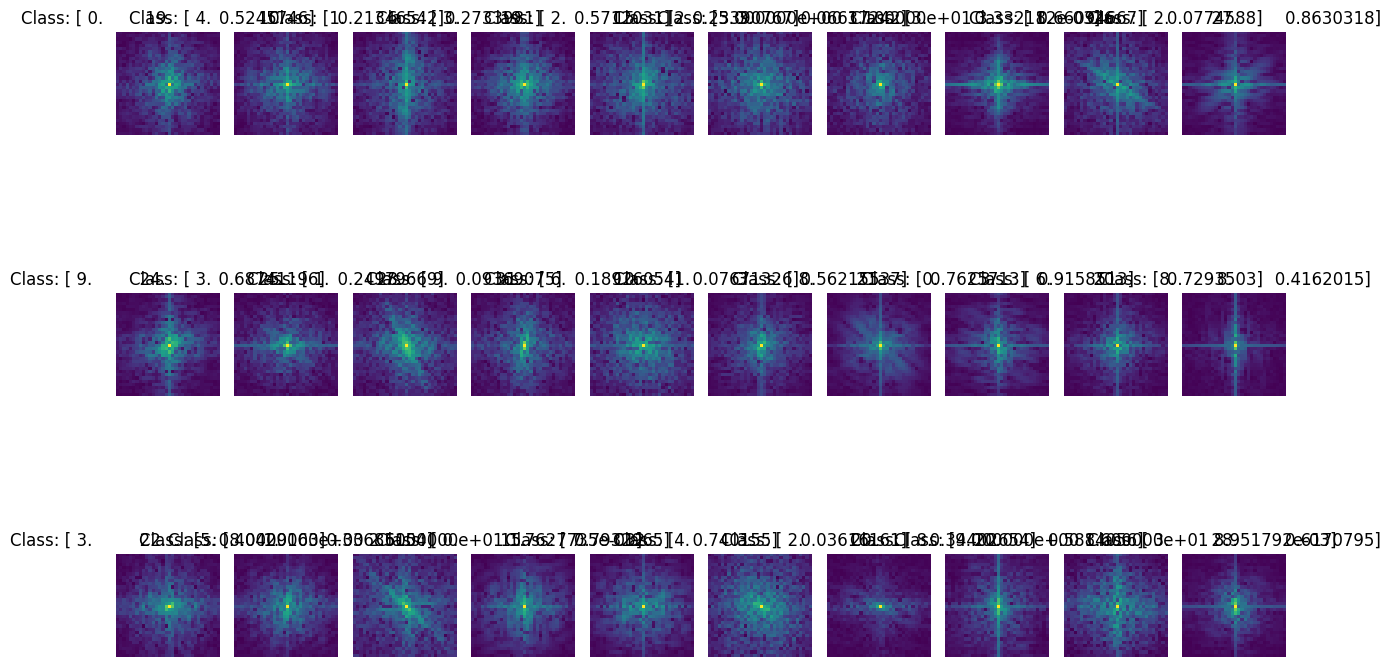

In [36]:
num_images = 30
rows = 3
cols = 10 

plt.figure(figsize=(12, 9))

# Pick 10 random indices
random_indices = np.random.choice(len(X), num_images, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[idx])
    plt.title(f"Class: {y[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing


In [37]:
# Normalize images
X = X.astype('float32') / 255.0

# Convert (16000, 32, 32) → (16000, 32, 32, 1)
X = X[..., np.newaxis]

y1 = y[:,0]              # Target A (0-9)
y2 = y[:,1]              # Target B (0-31)
y3 = y[:,2].astype('float32')  # Target C (regression)

y1_cat = to_categorical(y1, num_classes=10)  
y2_cat = to_categorical(y2, num_classes=32) 



In [38]:
X.shape

(3000, 32, 32, 1)

In [40]:
# Train test split at 80/20 ratio
X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(
    X, y[:,0], y[:,1], y[:,2],
    test_size=0.2,
    random_state=42
)
print(X_train.shape, y1_train.shape, y2_train.shape, y3_train.shape)
print(X_test.shape, y1_test.shape, y2_test.shape, y3_test.shape)

(2400, 32, 32, 1) (2400,) (2400,) (2400,)
(600, 32, 32, 1) (600,) (600,) (600,)


## Data Augmentation


In [41]:
X_train, X_val, y1_train, y1_val, y2_train, y2_val, y3_train, y3_val = train_test_split(
    X_train, y1_train, y2_train, y3_train, test_size=0.2, random_state=42
)

# Create Dataset from NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, (y1_train, y2_train, y3_train)))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, (y1_val, y2_val, y3_val)))

# Apply data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.04),
    layers.RandomZoom(0.1),
])

def augment(x, y):
    x = data_augmentation(x)
    return x, y

train_ds = train_ds.map(augment).batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(augment).batch(32).prefetch(tf.data.AUTOTUNE)

## Architecture


In [42]:
from tensorflow.keras import layers, Model

class AlexNet(Model):
    def __init__(self, input_shape = (32, 32, 1), num_classes=(10,32,1)):
        super(AlexNet, self).__init__()

        # Layer 1
        self.conv1 = layers.Conv2D(48, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape)
        self.relu1 = layers.Activation('relu')
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.bn1 = layers.BatchNormalization()

        # Layer 2
        self.conv2 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')
        self.relu2 = layers.Activation('relu')
        self.pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.bn2 = layers.BatchNormalization()

        # Layer 3
        self.conv3 = layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same')
        self.relu3 = layers.Activation('relu')

        # Layer 4
        self.conv4 = layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same')
        self.relu4 = layers.Activation('relu')

        # Layer 5
        self.conv5 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')
        self.relu5 = layers.Activation('relu')
        self.pool5 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        # Fully connected layers
        self.flatten = layers.Flatten()

        self.fc1_1 = layers.Dense(512)
        self.relu_fc1_1 = layers.Activation('relu')
        self.dropout1_1 = layers.Dropout(0.5)

        self.fc2_1 = layers.Dense(256)
        self.relu_fc2_1 = layers.Activation('relu')
        self.dropout2_1 = layers.Dropout(0.5)

        self.fc1_2 = layers.Dense(512)
        self.relu_fc1_2 = layers.Activation('relu')
        self.dropout1_2 = layers.Dropout(0.5)

        self.fc2_2 = layers.Dense(256)
        self.relu_fc2_2 = layers.Activation('relu')
        self.dropout2_2 = layers.Dropout(0.5)

        self.fc1_3 = layers.Dense(512)
        self.relu_fc1_3 = layers.Activation('relu')
        self.dropout1_3 = layers.Dropout(0.5)

        self.fc2_3 = layers.Dense(256)
        self.relu_fc2_3 = layers.Activation('relu')
        self.dropout2_3 = layers.Dropout(0.5)


        # Output layer
        self.output_layer_1 = layers.Dense(num_classes[0], activation='softmax')
        self.output_layer_2 = layers.Dense(num_classes[1], activation='softmax')
        self.output_layer_3 = layers.Dense(num_classes[2], activation='sigmoid')

    def call(self, x, training=False):
        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.bn1(x, training=training)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.bn2(x, training=training)

        # Layer 3
        x = self.conv3(x)
        x = self.relu3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.relu4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        # Flatten
        x = self.flatten(x)

        # First path
        x_1 = self.fc1_1(x)
        x_1 = self.relu_fc1_1(x_1)
        x_1 = self.dropout1_1(x_1, training=training)

        x_1 = self.fc2_1(x_1)
        x_1 = self.relu_fc2_1(x_1)
        x_1 = self.dropout2_1(x_1, training=training)
        output_1 = self.output_layer_1(x_1)

        # Second path
        x_2 = self.fc1_2(x)
        x_2 = self.relu_fc1_2(x_2)
        x_2 = self.dropout1_2(x_2, training=training)

        x_2 = self.fc2_2(x_2)
        x_2 = self.relu_fc2_2(x_2)
        x_2 = self.dropout2_2(x_2, training=training)
        output_2 = self.output_layer_2(x_2)

        # Third path
        x_3 = self.fc1_3(x)
        x_3 = self.relu_fc1_3(x_3)
        x_3 = self.dropout1_3(x_3, training=training)

        x_3 = self.fc2_3(x_3)
        x_3 = self.relu_fc2_3(x_3)
        x_3 = self.dropout2_3(x_3, training=training)
        output_3 = self.output_layer_3(x_3)


        # Output
        return (output_1, output_2, output_3)


In [43]:
optimizer = Adam(learning_rate=0.0001) 

model = AlexNet()
model.compile(
    optimizer=optimizer,
    loss=[
        'sparse_categorical_crossentropy',
        'sparse_categorical_crossentropy',
        'mse'
    ],
    metrics=[
        ['accuracy'],
        ['accuracy'],
        ['mse']
    ]
)

c:\Users\Admin\Desktop\DL\DL-ASM2\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
# dummy_input = tf.random.normal((1, 32, 32, 1))
# model(dummy_input)
# model.summary()

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the best model based on Target A (first output) validation accuracy
checkpoint = ModelCheckpoint(
    filepath='model_s3759957.h5',
    monitor='val_output_1_accuracy',  # monitor the first output's accuracy
    save_best_only=True,
    mode='max',
    verbose=1
)

# Training
history = model.fit(
    train_ds,          # tf.data.Dataset for training (X, (y1, y2, y3))
    validation_data=val_ds,  # tf.data.Dataset for validation
    epochs=30,
    verbose=1,
    callbacks=[checkpoint]
)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1253 - accuracy_1: 0.0355 - loss: 5.8588 - mse: 0.0783 - mse_loss: 0.0783 - sparse_categorical_crossentropy_loss: 3.4688

c:\Users\Admin\Desktop\DL\DL-ASM2\.venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with val_output_1_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.1219 - accuracy_1: 0.0292 - loss: 5.8532 - mse: 0.0761 - mse_loss: 0.0761 - sparse_categorical_crossentropy_loss: 3.4750 - val_accuracy: 0.1125 - val_accuracy_1: 0.0271 - val_loss: 5.8546 - val_mse: 0.0862 - val_mse_loss: 0.0862 - val_sparse_categorical_crossentropy_loss: 3.4659
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1330 - accuracy_1: 0.0262 - loss: 5.8306 - mse: 0.0652 - mse_loss: 0.0652 - sparse_categorical_crossentropy_loss: 3.4737

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.1375 - accuracy_1: 0.0333 - loss: 5.8160 - mse: 0.0638 - mse_loss: 0.0638 - sparse_categorical_crossentropy_loss: 3.4707 - val_accuracy: 0.0917 - val_accuracy_1: 0.0271 - val_loss: 5.8549 - val_mse: 0.0862 - val_mse_loss: 0.0862 - val_sparse_categorical_crossentropy_loss: 3.4660
Epoch 3/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1359 - accuracy_1: 0.0363 - loss: 5.7884 - mse: 0.0603 - mse_loss: 0.0603 - sparse_categorical_crossentropy_loss: 3.4691

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.1422 - accuracy_1: 0.0318 - loss: 5.7886 - mse: 0.0614 - mse_loss: 0.0614 - sparse_categorical_crossentropy_loss: 3.4691 - val_accuracy: 0.0854 - val_accuracy_1: 0.0188 - val_loss: 5.8564 - val_mse: 0.0869 - val_mse_loss: 0.0869 - val_sparse_categorical_crossentropy_loss: 3.4664
Epoch 4/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1471 - accuracy_1: 0.0443 - loss: 5.7573 - mse: 0.0589 - mse_loss: 0.0589 - sparse_categorical_crossentropy_loss: 3.4638

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.1615 - accuracy_1: 0.0422 - loss: 5.7597 - mse: 0.0577 - mse_loss: 0.0577 - sparse_categorical_crossentropy_loss: 3.4658 - val_accuracy: 0.0854 - val_accuracy_1: 0.0271 - val_loss: 5.8614 - val_mse: 0.0902 - val_mse_loss: 0.0902 - val_sparse_categorical_crossentropy_loss: 3.4670
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1878 - accuracy_1: 0.0333 - loss: 5.7422 - mse: 0.0570 - mse_loss: 0.0570 - sparse_categorical_crossentropy_loss: 3.4691

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.1943 - accuracy_1: 0.0365 - loss: 5.7150 - mse: 0.0560 - mse_loss: 0.0560 - sparse_categorical_crossentropy_loss: 3.4657 - val_accuracy: 0.0854 - val_accuracy_1: 0.0271 - val_loss: 5.8739 - val_mse: 0.0984 - val_mse_loss: 0.0984 - val_sparse_categorical_crossentropy_loss: 3.4684
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2039 - accuracy_1: 0.0393 - loss: 5.6787 - mse: 0.0537 - mse_loss: 0.0537 - sparse_categorical_crossentropy_loss: 3.4640

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2078 - accuracy_1: 0.0396 - loss: 5.6737 - mse: 0.0545 - mse_loss: 0.0545 - sparse_categorical_crossentropy_loss: 3.4616 - val_accuracy: 0.0854 - val_accuracy_1: 0.0333 - val_loss: 5.9160 - val_mse: 0.1178 - val_mse_loss: 0.1178 - val_sparse_categorical_crossentropy_loss: 3.4701
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2440 - accuracy_1: 0.0490 - loss: 5.5846 - mse: 0.0531 - mse_loss: 0.0531 - sparse_categorical_crossentropy_loss: 3.4613

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2344 - accuracy_1: 0.0448 - loss: 5.6065 - mse: 0.0533 - mse_loss: 0.0533 - sparse_categorical_crossentropy_loss: 3.4634 - val_accuracy: 0.0854 - val_accuracy_1: 0.0375 - val_loss: 6.0443 - val_mse: 0.1389 - val_mse_loss: 0.1389 - val_sparse_categorical_crossentropy_loss: 3.4751
Epoch 8/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2357 - accuracy_1: 0.0290 - loss: 5.5664 - mse: 0.0563 - mse_loss: 0.0563 - sparse_categorical_crossentropy_loss: 3.4583

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2323 - accuracy_1: 0.0349 - loss: 5.5757 - mse: 0.0554 - mse_loss: 0.0554 - sparse_categorical_crossentropy_loss: 3.4592 - val_accuracy: 0.0854 - val_accuracy_1: 0.0354 - val_loss: 6.2840 - val_mse: 0.1563 - val_mse_loss: 0.1563 - val_sparse_categorical_crossentropy_loss: 3.4843
Epoch 9/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2482 - accuracy_1: 0.0650 - loss: 5.5590 - mse: 0.0527 - mse_loss: 0.0527 - sparse_categorical_crossentropy_loss: 3.4526

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2635 - accuracy_1: 0.0490 - loss: 5.5363 - mse: 0.0516 - mse_loss: 0.0516 - sparse_categorical_crossentropy_loss: 3.4570 - val_accuracy: 0.0854 - val_accuracy_1: 0.0271 - val_loss: 6.8231 - val_mse: 0.1869 - val_mse_loss: 0.1869 - val_sparse_categorical_crossentropy_loss: 3.4994
Epoch 10/30
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2376 - accuracy_1: 0.0487 - loss: 5.5327 - mse: 0.0514 - mse_loss: 0.0514 - sparse_categorical_crossentropy_loss: 3.4455

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2464 - accuracy_1: 0.0500 - loss: 5.5298 - mse: 0.0528 - mse_loss: 0.0528 - sparse_categorical_crossentropy_loss: 3.4501 - val_accuracy: 0.0854 - val_accuracy_1: 0.0271 - val_loss: 6.5870 - val_mse: 0.1620 - val_mse_loss: 0.1620 - val_sparse_categorical_crossentropy_loss: 3.5040
Epoch 11/30
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2586 - accuracy_1: 0.0439 - loss: 5.4877 - mse: 0.0543 - mse_loss: 0.0543 - sparse_categorical_crossentropy_loss: 3.4422

KeyboardInterrupt: 